# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-04-18 14:37:41,091 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [2]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


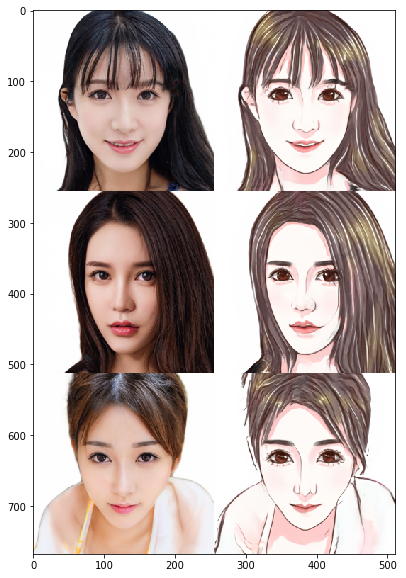

In [3]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [7]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])                                        # 读取一组数据
        img_A2B = img_A2B.astype('float32')/127.5-1.                                        # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose(2,0,1)                                        # 维度变换HWC -> CHW
        img_A =  img_A2B[...,:256]                                         # 真人照
        img_B =  img_A2B[...,256:]                                         # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [15]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [10]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),                    # LeakyReLU, leaky=0.2
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),                    # Conv2D
            nn.BatchNorm2D(out_dim)                    # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),                    # ReLU
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),                   # Conv2DTranspose
            nn.BatchNorm2D(out_dim)                    # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [11]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),                    # Conv2D
            nn.BatchNorm2D(out_dim),                    # BatchNorm2D
            nn.LeakyReLU(0.2)                    # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [12]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [13]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [16]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [17]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) 
        g_loss = g_bce_loss + g_l1_loss * 100.
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [1/100] Loss D: [0.5684284], Loss G: [13.770082]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [2/100] Loss D: [0.55869377], Loss G: [12.019674]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [3/100] Loss D: [0.5248891], Loss G: [10.967061]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [4/100] Loss D: [0.53293467], Loss G: [11.20265]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [5/100] Loss D: [0.5454856], Loss G: [10.960699]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [6/100] Loss D: [0.6126503], Loss G: [11.072103]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [7/100] Loss D: [0.6595552], Loss G: [11.496133]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch [8/100] Loss D: [0.685619], Loss G: [9.959497]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [9/100] Loss D: [0.5610679], Loss G: [9.84764]


  2%|▏         | 3/170 [00:00<00:22,  7.28it/s]100%|██████████| 170/170 [00:22<00:00,  7.45it/s]


Epoch [10/100] Loss D: [0.57124364], Loss G: [10.143892]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch [11/100] Loss D: [0.6028099], Loss G: [9.204297]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [12/100] Loss D: [0.5642947], Loss G: [9.261819]


  1%|          | 1/170 [00:00<00:23,  7.11it/s]

Epoch [13/100] Loss D: [0.67762417], Loss G: [9.236584]


  1%|          | 1/170 [00:00<00:25,  6.63it/s]

Epoch [14/100] Loss D: [0.6182617], Loss G: [8.317657]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [15/100] Loss D: [0.76152813], Loss G: [8.723752]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [16/100] Loss D: [0.67394245], Loss G: [8.877718]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [17/100] Loss D: [0.6089208], Loss G: [8.353294]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [18/100] Loss D: [0.6496659], Loss G: [7.8988423]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [19/100] Loss D: [0.5854235], Loss G: [7.9448004]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]100%|██████████| 170/170 [00:22<00:00,  7.42it/s]


Epoch [20/100] Loss D: [0.6276385], Loss G: [7.8752246]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [21/100] Loss D: [0.608623], Loss G: [7.8360095]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [22/100] Loss D: [0.7471791], Loss G: [8.00353]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [23/100] Loss D: [0.9451869], Loss G: [7.128318]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch [24/100] Loss D: [0.58308184], Loss G: [6.779035]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch [25/100] Loss D: [0.60017824], Loss G: [7.2375555]


  1%|          | 1/170 [00:00<00:30,  5.62it/s]

Epoch [26/100] Loss D: [0.6079572], Loss G: [6.933307]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [27/100] Loss D: [0.6675595], Loss G: [6.622615]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [28/100] Loss D: [0.67575073], Loss G: [6.582013]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [29/100] Loss D: [0.6144024], Loss G: [6.8161087]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]100%|██████████| 170/170 [00:22<00:00,  7.44it/s]


Epoch [30/100] Loss D: [0.6025437], Loss G: [6.544037]


  1%|          | 1/170 [00:00<00:24,  6.92it/s]

Epoch [31/100] Loss D: [0.58013827], Loss G: [6.347594]


  1%|          | 1/170 [00:00<00:24,  6.77it/s]

Epoch [32/100] Loss D: [0.9444151], Loss G: [6.7605543]


  1%|          | 1/170 [00:00<00:25,  6.61it/s]

Epoch [33/100] Loss D: [0.59288096], Loss G: [6.3417344]


  1%|          | 1/170 [00:00<00:25,  6.69it/s]

Epoch [34/100] Loss D: [0.6424638], Loss G: [6.444966]


  1%|          | 1/170 [00:00<00:24,  6.92it/s]

Epoch [35/100] Loss D: [0.6268985], Loss G: [5.825704]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [36/100] Loss D: [0.6592897], Loss G: [6.454531]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [37/100] Loss D: [0.60996366], Loss G: [6.0500813]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch [38/100] Loss D: [0.6656307], Loss G: [5.7859807]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [39/100] Loss D: [0.6422509], Loss G: [5.735428]


  4%|▎         | 6/170 [00:00<00:22,  7.44it/s]100%|██████████| 170/170 [00:22<00:00,  7.55it/s]


Epoch [40/100] Loss D: [0.7996347], Loss G: [5.4979253]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch [41/100] Loss D: [0.61614776], Loss G: [5.701732]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [42/100] Loss D: [0.5794227], Loss G: [5.590801]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [43/100] Loss D: [0.66023606], Loss G: [5.5709767]


  1%|          | 1/170 [00:00<00:24,  6.82it/s]

Epoch [44/100] Loss D: [0.6238477], Loss G: [5.2113905]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [45/100] Loss D: [0.62905115], Loss G: [5.612668]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [46/100] Loss D: [0.6587734], Loss G: [5.413456]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [47/100] Loss D: [0.6399693], Loss G: [5.3465137]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch [48/100] Loss D: [0.62487376], Loss G: [5.349256]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [49/100] Loss D: [0.6836432], Loss G: [5.246696]


  2%|▏         | 4/170 [00:00<00:22,  7.31it/s]100%|██████████| 170/170 [00:22<00:00,  7.52it/s]


Epoch [50/100] Loss D: [0.6294043], Loss G: [5.027581]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [51/100] Loss D: [0.6219857], Loss G: [4.977755]


  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [52/100] Loss D: [0.62309796], Loss G: [5.243037]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch [53/100] Loss D: [0.65105116], Loss G: [5.1808453]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [54/100] Loss D: [0.6412138], Loss G: [5.2147903]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [55/100] Loss D: [0.6872288], Loss G: [5.4409475]


  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch [56/100] Loss D: [0.63140565], Loss G: [4.912954]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [57/100] Loss D: [0.66414416], Loss G: [5.085557]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [58/100] Loss D: [0.6519664], Loss G: [4.868375]


  1%|          | 1/170 [00:00<00:23,  7.21it/s]

Epoch [59/100] Loss D: [0.62488174], Loss G: [5.141627]


  2%|▏         | 3/170 [00:00<00:22,  7.39it/s]100%|██████████| 170/170 [00:22<00:00,  7.43it/s]


Epoch [60/100] Loss D: [0.68540466], Loss G: [4.8232155]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [61/100] Loss D: [0.6526724], Loss G: [5.1044126]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [62/100] Loss D: [0.65393794], Loss G: [5.171841]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [63/100] Loss D: [0.64882606], Loss G: [5.420448]


  1%|          | 1/170 [00:00<00:26,  6.41it/s]

Epoch [64/100] Loss D: [0.62682205], Loss G: [5.0266495]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [65/100] Loss D: [0.65826786], Loss G: [4.6230755]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [66/100] Loss D: [0.6739115], Loss G: [4.9106903]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [67/100] Loss D: [0.63977206], Loss G: [4.7780747]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [68/100] Loss D: [0.6635622], Loss G: [4.7975454]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [69/100] Loss D: [0.63867414], Loss G: [4.7406516]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]100%|██████████| 170/170 [00:22<00:00,  7.50it/s]


Epoch [70/100] Loss D: [0.66177887], Loss G: [4.546592]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch [71/100] Loss D: [0.6499047], Loss G: [4.6136193]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [72/100] Loss D: [0.6232133], Loss G: [4.5980697]


  1%|          | 1/170 [00:00<00:25,  6.72it/s]

Epoch [73/100] Loss D: [0.6465763], Loss G: [4.274951]


  1%|          | 1/170 [00:00<00:24,  6.81it/s]

Epoch [74/100] Loss D: [0.6436864], Loss G: [4.613984]


  1%|          | 1/170 [00:00<00:26,  6.31it/s]

Epoch [75/100] Loss D: [0.6512532], Loss G: [4.7630963]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch [76/100] Loss D: [0.70232135], Loss G: [4.392871]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [77/100] Loss D: [0.63752764], Loss G: [4.6920404]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [78/100] Loss D: [0.6641195], Loss G: [4.526615]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [79/100] Loss D: [0.6766474], Loss G: [4.529355]


  1%|          | 2/170 [00:00<00:23,  7.24it/s]100%|██████████| 170/170 [00:22<00:00,  7.50it/s]


Epoch [80/100] Loss D: [0.6722194], Loss G: [4.391073]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [81/100] Loss D: [0.6552752], Loss G: [4.3125725]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [82/100] Loss D: [0.6602987], Loss G: [4.4619856]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [83/100] Loss D: [0.6781164], Loss G: [4.1477103]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [84/100] Loss D: [0.66742516], Loss G: [4.398453]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [85/100] Loss D: [0.6237521], Loss G: [4.543746]


  1%|          | 1/170 [00:00<00:23,  7.15it/s]

Epoch [86/100] Loss D: [0.6608422], Loss G: [4.0871563]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [87/100] Loss D: [0.65645707], Loss G: [4.2446966]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [88/100] Loss D: [0.64896524], Loss G: [3.9561014]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [89/100] Loss D: [0.6633356], Loss G: [4.29473]


  1%|          | 2/170 [00:00<00:23,  7.02it/s]100%|██████████| 170/170 [00:22<00:00,  7.47it/s]


Epoch [90/100] Loss D: [0.6749259], Loss G: [4.312275]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch [91/100] Loss D: [0.63487494], Loss G: [4.2083755]


  1%|          | 1/170 [00:00<00:25,  6.58it/s]

Epoch [92/100] Loss D: [0.65187407], Loss G: [4.291601]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [93/100] Loss D: [0.64474905], Loss G: [4.3668394]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [94/100] Loss D: [0.64160866], Loss G: [4.046948]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [95/100] Loss D: [0.6643299], Loss G: [4.2474046]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [96/100] Loss D: [0.6544445], Loss G: [4.1107244]


  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [97/100] Loss D: [0.68088317], Loss G: [4.07278]


  1%|          | 1/170 [00:00<00:24,  6.76it/s]

Epoch [98/100] Loss D: [0.64891016], Loss G: [3.950766]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [99/100] Loss D: [0.6330079], Loss G: [4.1855574]


  1%|          | 2/170 [00:00<00:23,  7.11it/s]100%|██████████| 170/170 [00:22<00:00,  7.48it/s]


Epoch [100/100] Loss D: [0.63997984], Loss G: [4.364224]


## 最后：用你补齐的代码试试卡通化的效果吧！

In [18]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch100.pdparams


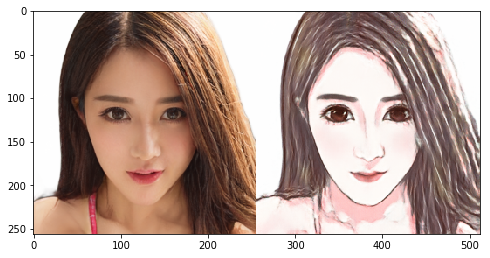

In [19]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()